In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
import cv2
%matplotlib inline

In [53]:
img = cv2.imread('content.png')

In [54]:
img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

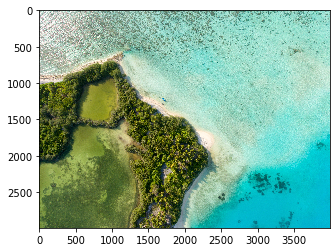

In [55]:
plt.imshow(img)

In [56]:
r,g,b = cv2.split(img)
r = r.flatten()
g = g.flatten()
b = b.flatten()

In [57]:
fig = plt.figure()
ax = Axes3D(fig)
ax.scatter(r,g,b)
plt.show()

KeyboardInterrupt: 

In [19]:
#COLOR CLUSTERING

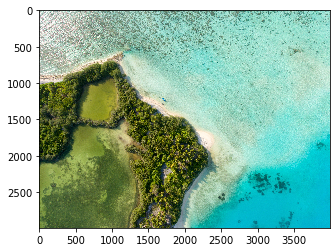

In [58]:
plt.imshow(img)

In [59]:
vectorized = img.reshape((-1,3))

In [60]:
vectorized = np.float32(vectorized)

In [61]:
criteria = (cv2.TERM_CRITERIA_EPS + cv2.TERM_CRITERIA_MAX_ITER,10,0.1)
K  = 3
attempts = 10 #to start with different labelings to yeild best compactness

ret, label, center = cv2.kmeans(vectorized, K, None, criteria, attempts, cv2.KMEANS_PP_CENTERS)

In [62]:
center = np.uint8(center)

In [63]:
res = center[label.flatten()]

In [64]:
result_image = res.reshape((img.shape))

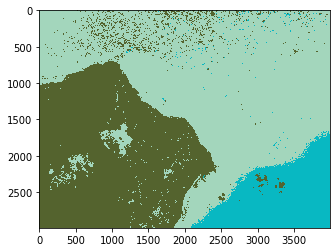

In [65]:
plt.imshow(result_image)

In [2]:
#Semantic Segmentation (FCNN)

In [18]:
import numpy as np
import pandas as pd
import tensorflow as tf
from tensorflow import keras
import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
import os

In [78]:
BASE_DIR = os.getcwd()
TRAIN_DIR = '/dataset1/images_prepped_train/'
ANN_TRAIN = '/dataset1/annotations_prepped_train/'

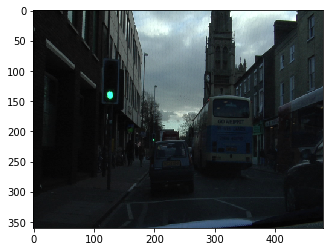

In [13]:
plt.imshow(plt.imread(os.listdir()[1]))

In [54]:
os.chdir(BASE_DIR+ANN_TRAIN)
np.unique(plt.imread(os.listdir()[1])).shape

(10,)

In [14]:
(input_height, input_width) = (360, 480)

In [7]:
import imgaug as ia
import imgaug.augmenters as iaa

seq = iaa.Sequential([
    iaa.Crop(px=(0, 16)), # crop images from each side by 0 to 16px (randomly chosen)
    iaa.Fliplr(0.5), # horizontally flip 50% of the images
    iaa.GaussianBlur(sigma=(0, 3.0)) # blur images with a sigma of 0 to 3.0
])

def augment_seg( img , seg  ):
	
	aug_det = seq.to_deterministic() 
	image_aug = aug_det.augment_image( img )

	segmap = ia.SegmentationMapOnImage( seg , nb_classes=np.max(seg)+1 , shape=img.shape )
	segmap_aug = aug_det.augment_segmentation_maps( segmap )
	segmap_aug = segmap_aug.get_arr_int()

	return image_aug , segmap_aug

In [98]:
import keras

In [99]:
from keras.layers import Conv2D, MaxPooling2D, Dropout, UpSampling2D,concatenate

In [100]:
img_input = keras.Input(shape=(input_height, input_width, 3))

#Encoder
conv1 = keras.layers.Conv2D(32, (3,3), activation='relu', padding='same')(img_input)
conv1 = keras.layers.Dropout(0.2)(conv1)
conv1 = keras.layers.Conv2D(32, (3,3), activation='relu', padding='same')(conv1)
pool1 = keras.layers.MaxPooling2D((2,2))(conv1)

conv2 = keras.layers.Conv2D(64,(3,3), activation ='relu', padding='same')(pool1)
conv2 = keras.layers.Dropout(0.2)(conv2)
conv2 = keras.layers.Conv2D(64, (3,3), activation ='relu', padding ='same')(conv2)
pool2 = keras.layers.MaxPooling2D((2,2))(conv2)

In [101]:
conv2

<tf.Tensor 'conv2d_16_1/Relu:0' shape=(?, 180, 240, 64) dtype=float32>

In [102]:
#Decoder
conv3 = Conv2D(128, (3, 3), activation='relu', padding='same')(pool2)
conv3 = Dropout(0.2)(conv3)
conv3 = Conv2D(128, (3, 3), activation='relu', padding='same')(conv3)

In [103]:
conv3

<tf.Tensor 'conv2d_18_1/Relu:0' shape=(?, 90, 120, 128) dtype=float32>

In [104]:
up1 = concatenate([UpSampling2D((2,2))(conv3), conv2],axis=-1)
conv4 = Conv2D(64, (3,3), activation='relu', padding ='same')(up1)
conv4 = Dropout(0.2)(conv4)
conv4 = Conv2D(64, (3,3), activation='relu', padding = 'same')(conv4)

up2 = concatenate([UpSampling2D((2, 2))(conv4), conv1], axis=-1)
conv5 = Conv2D(32, (3, 3), activation='relu', padding='same')(up2)
conv5 = Dropout(0.2)(conv5)
conv5 = Conv2D(32, (3, 3), activation='relu', padding='same')(conv5)

In [105]:
out = Conv2D(10, (1,1), padding='same')(conv5)

In [106]:
from keras_segmentation.models.model_utils import get_segmentation_model

model = get_segmentation_model(img_input, out)

In [128]:
model.train( 
    train_images =  'C:\\Users\\HP\\Desktop\\Deep learning and tensorflow\\dataset1\\images_prepped_train',
    train_annotations = 'C:\\Users\\HP\\Desktop\\Deep learning and tensorflow\\dataset1\\annotations_prepped_train',
    epochs=5
)

Verifying train dataset


100%|███████████████████████████████████████████████████████████████████████████████| 367/367 [00:02<00:00, 171.93it/s]


Dataset verified! 
Starting Epoch  0
Epoch 1/1
  6/512 [..............................] - ETA: 3:36:18 - loss: 3.0003 - acc: 0.03 - ETA: 3:40:53 - loss: 2.5734 - acc: 0.28 - ETA: 3:55:29 - loss: 2.4968 - acc: 0.32 - ETA: 4:00:54 - loss: 2.3756 - acc: 0.36 - ETA: 3:59:06 - loss: 2.2785 - acc: 0.39 - ETA: 4:00:19 - loss: 2.2196 - acc: 0.3994

KeyboardInterrupt: 

In [122]:
#utils_model
import keras_segmentation

model = keras_segmentation.models.unet.vgg_unet(n_classes=12 ,  input_height=416, input_width=608  )